In [1]:
# Importing model
import sys
sys.path.append("..")
from model_analysis.jnk3_no_ask1 import model
from simplepso.pso import PSO
from pysb.simulator import ScipyOdeSimulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from model_analysis.equilibration_function import pre_equilibration

In [2]:
# Loading data
exp_data = pd.read_csv('../data/exp_data_3min.csv')

In [3]:
# Indices of model parameters that are going to be calibrated
idx_pars_calibrate = [1, 5, 9, 11, 15, 17, 19, 23, 25, 27, 31, 35, 36, 37, 38, 39, 41, 43] #pydream3
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

In [4]:
# Index of Initial conditions of Arrestin
arrestin_idx = [44]
jnk3_initial_value = 0.6  # total jnk3
jnk3_initial_idxs = [47, 48, 49]
kcat_idx = [36, 37]

param_values = np.array([p.value for p in model.parameters])
nominal_values = np.array([p.value for p in model.parameters])
# xnominal = np.log10(nominal_values[rates_of_interest_mask])
xnominal = np.load('../model_analysis/most_likely_par_500000_4box.npy')
lower = xnominal - 2
upper = xnominal + 2

In [5]:
# Setting the solver
tspan = np.linspace(0, exp_data['Time (secs)'].values[-1], 181)
t_exp_mask = [idx in exp_data['Time (secs)'].values[:] for idx in tspan]

solver = ScipyOdeSimulator(model, tspan=tspan)

In [6]:
def display(position):
    Y = np.copy(position)
    param_values[rates_of_interest_mask] = 10 ** Y

    pars1 = np.copy(param_values)
    pars2 = np.copy(param_values)

    # Pre-equilibration
    time_eq = np.linspace(0, 100, 100)
    pars_eq1 = np.copy(param_values)
    pars_eq2 = np.copy(param_values)

    pars_eq2[arrestin_idx] = 0
    # pars_eq2[jnk3_initial_idxs] = [0.5958, 0, 0.0042]

    all_pars = np.stack((pars_eq1, pars_eq2))
    all_pars[:, kcat_idx] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc = pre_equilibration(model, time_eq, all_pars)[1]

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    pars2[arrestin_idx] = 0
    # pars2[jnk3_initial_idxs] = [0.5958, 0, 0.0042]
    sim = solver.run(param_values=[pars1, pars2], initials=eq_conc).all

    plt.plot(tspan, sim[0]['pTyr_jnk3'] / jnk3_initial_value, color='red', label='p(Tyr)JNK3 sim')
    plt.errorbar(exp_data['Time (secs)'].values, exp_data['pTyr_arrestin_avg'].values,
                 exp_data['pTyr_arrestin_std'].values,
                 linestyle='None', marker='o', capsize=5, color='red', label='p(Tyr)JNK3 exp')

    plt.plot(tspan, sim[0]['pThr_jnk3'] / jnk3_initial_value, color='blue', label='p(Thr)JNK3 sim')
    plt.errorbar(exp_data['Time (secs)'].values, exp_data['pThr_arrestin_avg'].values,
                 exp_data['pThr_arrestin_std'].values,
                 linestyle='None', marker='o', capsize=5, color='blue', label='p(Thr)JNK3 exp')

    # plt.plot(tspan, sim[0]['all_jnk3'] / jnk3_initial_value, color='cyan', label='ppJNK3 sim')
    # plt.errorbar(exp_data['Time (secs)'].values, exp_data['ppjnk3_arrestin_avg'].values,
    #              exp_data['ppjnk3_arrestin_std'].values,
    #              linestyle='None', marker='o', capsize=5, color='cyan', label='ppJNK3 exp')

    plt.plot(tspan, sim[1]['pTyr_jnk3'] / jnk3_initial_value, color='black', label='p(Tyr)JNK3 -Arr sim')
    plt.errorbar(exp_data['Time (secs)'].values, exp_data['pTyr_noarrestin_avg'].values,
                 exp_data['pTyr_noarrestin_std'].values,
                 linestyle='None', marker='o', capsize=5, color='black', label='p(Tyr)JNK3 -Arr exp')

    plt.plot(tspan, sim[1]['pThr_jnk3'] / jnk3_initial_value, color='green', label='p(Thr)JNK3 -Arr sim')
    plt.errorbar(exp_data['Time (secs)'].values, exp_data['pThr_noarrestin_avg'].values,
                 exp_data['pThr_noarrestin_std'].values,
                 linestyle='None', marker='o', capsize=5, color='green', label='p(Thr)JNK3 -Arr exp')

    # plt.plot(tspan, sim[1]['all_jnk3'] / jnk3_initial_value, color='purple', label='ppJNK3 -Arr sim')
    # plt.errorbar(exp_data['Time (secs)'].values, exp_data['ppjnk3_noarrestin_avg'].values,
    #              exp_data['ppjnk3_noarrestin_std'].values,
    #              linestyle='None', marker='o', capsize=5, color='purple', label='ppJNK3 -Arr exp')

    plt.xlabel('Arrestin (microM)')
    plt.ylabel('pJNK3 (microM)')
    # plt.legend()
#     plt.savefig('jnk3_noASK1_trained_pso_1h.png')
    plt.show()

In [7]:
# Sum of squared errors function to measure the difference between
# the experimental data and the simulated trajectories
def likelihood(position):
    Y = np.copy(position)
    param_values[rates_of_interest_mask] = 10 ** Y

    pars1 = np.copy(param_values)
    pars2 = np.copy(param_values)

    # Pre-equilibration
    time_eq = np.linspace(0, 100, 100)
    pars_eq1 = np.copy(param_values)
    pars_eq2 = np.copy(param_values)

    pars_eq2[arrestin_idx] = 0
    # pars_eq2[jnk3_initial_idxs] = [0.5958, 0, 0.0042]

    all_pars = np.stack((pars_eq1, pars_eq2))
    all_pars[:, kcat_idx] = 0  # Setting catalytic reactions to zero for pre-equilibration
    try:
        eq_conc = pre_equilibration(model, time_eq, all_pars)[1]
    except:
        return np.inf,

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    pars2[arrestin_idx] = 0
    # pars2[jnk3_initial_idxs] = [0.5958, 0, 0.0042]
    sim = solver.run(param_values=[pars1, pars2], initials=eq_conc).all

    e_mkk4 = np.sum((exp_data['pTyr_arrestin_avg'].values - sim[0]['pTyr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                    (exp_data['pTyr_arrestin_std'].values**2))
    e_mkk7 = np.sum((exp_data['pThr_arrestin_avg'].values - sim[0]['pThr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                    (exp_data['pThr_arrestin_std'].values**2))
    # e_ppjnk3 = np.sum((exp_data['ppjnk3_arrestin_avg'].values - sim[0]['all_jnk3'][t_exp_mask] / jnk3_initial_value) **2 /
    #                   (2 * exp_data['ppjnk3_arrestin_std'].values)) / len(exp_data['ppjnk3_arrestin_std'].values)
    error1 = e_mkk4 + e_mkk7

    e2_mkk4 = np.sum((exp_data['pTyr_noarrestin_avg'].values - sim[1]['pTyr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                     (exp_data['pTyr_noarrestin_std'].values**2))
    e2_mkk7 = np.sum((exp_data['pThr_noarrestin_avg'].values - sim[1]['pThr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                     (exp_data['pThr_noarrestin_std'].values**2))
    # e2_ppjnk3 = np.sum((exp_data['ppjnk3_noarrestin_avg'].values - sim[1]['all_jnk3'][t_exp_mask] / jnk3_initial_value) **2 /
    #                   (2 * exp_data['ppjnk3_noarrestin_std'].values)) / len(exp_data['ppjnk3_noarrestin_std'].values)

    box1 = (pars1[21]/pars1[20]) * (pars1[23]/pars1[22]) * (1 / (pars1[1] / pars1[0])) * \
           (1 / (pars1[5]/pars1[4]))

    box2 = (pars1[21] / pars1[20]) * (pars1[25] / pars1[24]) * (1 / (pars1[3] / pars1[2])) * \
           (1 / (pars1[27] / pars1[26]))

    box3 = (pars1[13] / pars1[12]) * (pars1[23] / pars1[22]) * (1 / (pars1[1] / pars1[0])) * \
           (1 / (pars1[15] / pars1[14]))

    box4 = (pars1[7] / pars1[6]) * (pars1[25] / pars1[24]) * (1 / (pars1[3] / pars1[2])) * \
           (1 / (pars1[11] / pars1[10]))

    boxes = np.array([box1, box2, box3, box4])
    boxes_error = np.sum((boxes - 1)**2)

    error2 = e2_mkk4 + e2_mkk7
    error = error1 + error2 + boxes_error
    return error,


iteration	best   	avg  	std  	min           	max  
         	597.686	[inf]	[nan]	[597.68576819]	[inf]
         	471.905	[inf]	[nan]	[471.90485827]	[inf]
         	350.356	[inf]	[nan]	[350.35606098]	[inf]
         	245.632	[inf]	[nan]	[245.63228099]	[inf]
         	170.849	[inf]	[nan]	[170.84889046]	[inf]
         	170.849	[inf]	[nan]	[173.03512697]	[inf]
         	129.895	[inf]	[nan]	[129.89459343]	[inf]
         	129.895	[inf]	[nan]	[139.79109259]	[inf]
         	106.457	[inf]	[nan]	[106.45725785]	[inf]
         	106.457	[inf]	[nan]	[110.52220455]	[inf]
         	106.457	[inf]	[nan]	[111.50789064]	[inf]
         	106.457	[inf]	[nan]	[119.9842446] 	[inf]
         	106.457	[inf]	[nan]	[127.14368028]	[inf]
         	101.859	[inf]	[nan]	[101.85878243]	[inf]
         	91.805 	[inf]	[nan]	[91.80497522] 	[inf]
         	91.805 	[inf]	[nan]	[97.13910462] 	[inf]
         	69.9608	[inf]	[nan]	[69.96078309] 	[inf]
         	69.9608	[inf]	[nan]	[80.72352452] 	[inf]
         	69.9608	[inf]	[nan]	[

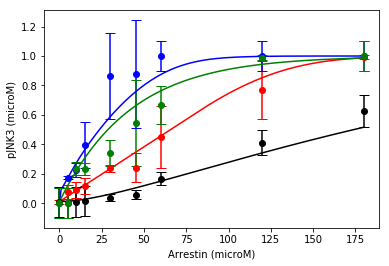

In [8]:
# Running the Particle Swarm Optimization algorithm
pso = PSO(save_sampled=False, verbose=True, num_proc=4)
pso.set_cost_function(likelihood)
pso.set_start_position(xnominal)
pso.set_bounds(lower=lower, upper=upper)
pso.set_speed(-.25, .25)
pso.run(25, 100)
display(pso.best)
